## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"",
             "key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
import kaggle

In [4]:
!kaggle competitions download -c ieee-fraud-detection

ieee-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip ieee-fraud-detection

Archive:  ieee-fraud-detection.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
train_transaction.isFraud = train_transaction.isFraud.astype('str')

test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

In [7]:
# трейн
X_train =  train_transaction.drop('isFraud', axis=1)
X_train = X_train.merge(train_identity, how='outer', on='TransactionID')

y_train = train_transaction['isFraud']

# тест
X_test = test_transaction.merge(test_identity, how='outer', on='TransactionID')

## EDA

### TransactionDT

Text(0.5, 1.0, 'Test')

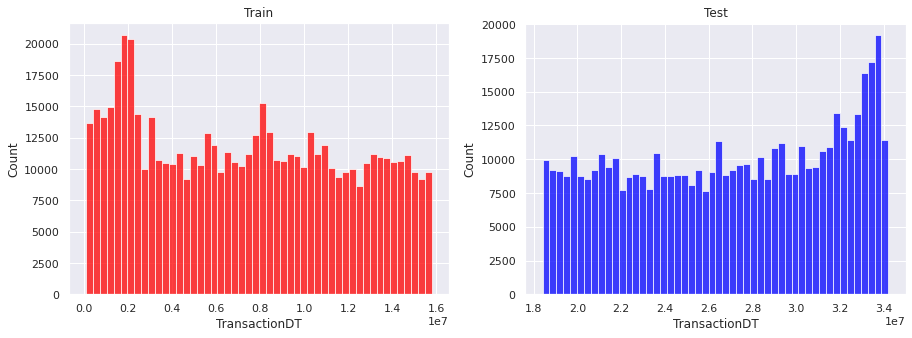

In [8]:
import seaborn as sns 
sns.set()

params = {
    'x': "TransactionDT",
    'bins': 50,
    'log_scale': False
}

params_train = {
    'data': train_transaction,
    'color': 'red'
}

params_test = {
    'data': test_transaction,
    'color': 'blue'
}

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(**params_train, 
             **params, 
             ax=ax[0])
sns.histplot(**params_test,
             **params, 
             ax=ax[1])

ax[0].set_title('Train')
ax[1].set_title('Test')

В трейне таймдельта распределена от 0 до 1.5, в то время как в тесте - от 2 до 3.5. Возможно, признак будет не очень информативным для модели. Имеет смысл поиграться и попробовать достать другие фичи из него.

### TransactionAMT




Text(0.5, 1.0, 'Not Fraud')

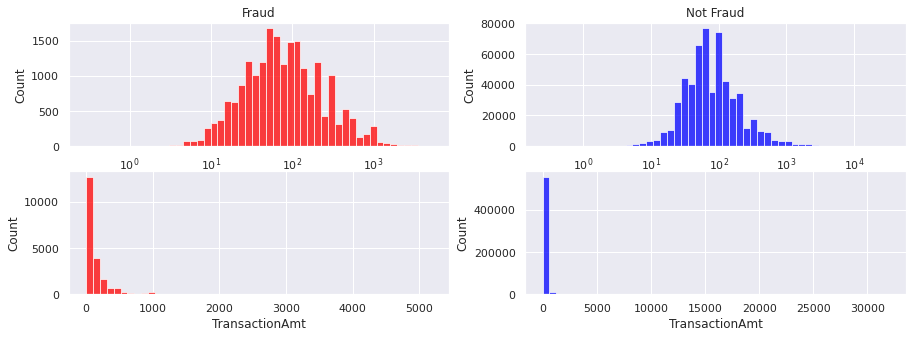

In [9]:
params = {
    'x': "TransactionAmt",
    'bins': 50,
    'log_scale': True
}

params_fraud = {
    'data': train_transaction.query('isFraud == "1"'),
    'color': 'red'
}

params_not_fraud = {
    'data': train_transaction.query('isFraud == "0"'),
    'color': 'blue'
}

fig, ax = plt.subplots(2, 2, figsize=(15, 5))

sns.histplot(**params_fraud, 
             **params, 
             ax=ax[0][0])
sns.histplot(**params_not_fraud,
             **params, 
             ax=ax[0][1])

params['log_scale'] = False

sns.histplot(**params_fraud, 
             **params, 
             ax=ax[1][0])
sns.histplot(**params_not_fraud,
             **params, 
             ax=ax[1][1])

ax[0][0].set_title('Fraud')
ax[0][1].set_title('Not Fraud')

Сумма транзакций с меткой фрод обычно меньше, чем сумма транзакций без метки фрода. Большая часть транзакций с меткой фроде лежит в границах до 1000 у.е.


### ProductCD

In [10]:
grouped = train_transaction.groupby(['ProductCD', 'isFraud'])['TransactionID'].count().reset_index()

Text(0.5, 1.0, 'Not Fraud')

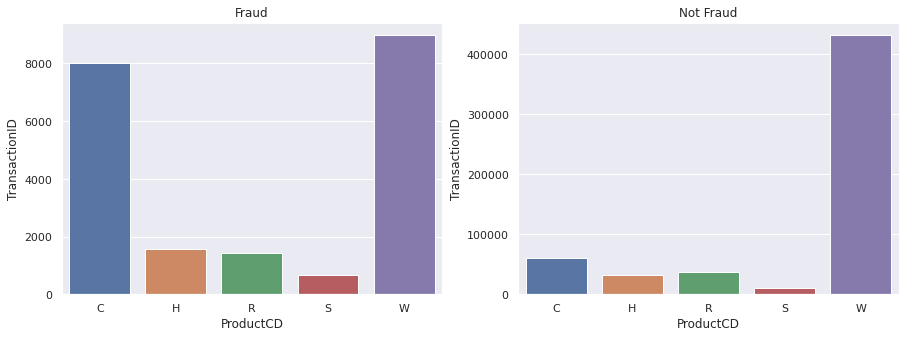

In [11]:
products = train_transaction['ProductCD'].unique()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, prod in enumerate(['1', '0']):
  tmp = grouped.query(f'isFraud == "{prod}"')
  sns.barplot(data=tmp,
              x='ProductCD',
              y='TransactionID',
              ax=ax[i])
  
ax[0].set_title('Fraud')
ax[1].set_title('Not Fraud')

Видно, что у транзакций с меткой фрод больше продуктов типа C и W, в то время как у транзакций без метки чаще встречается продукт типа W.

### card1, card2, card3, card5

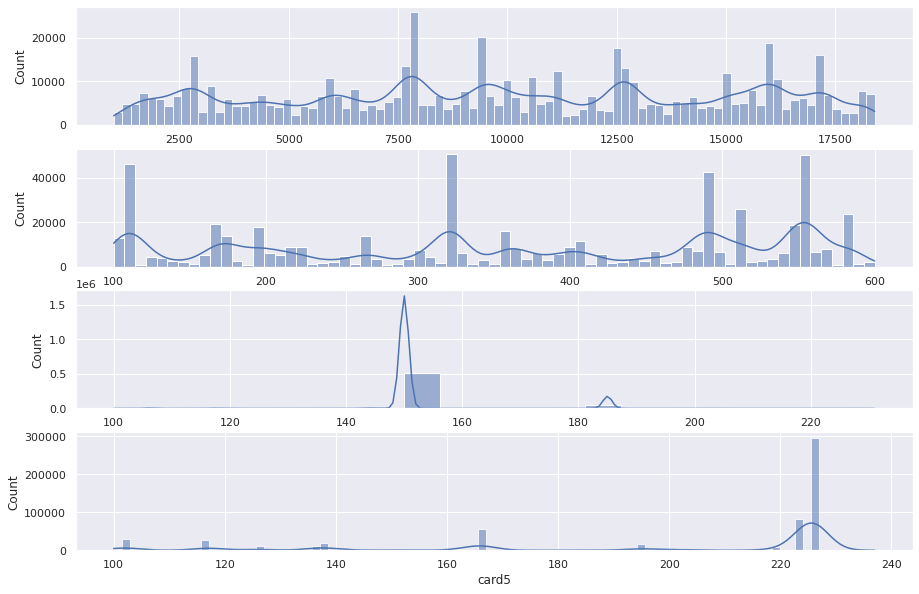

In [12]:
card_num_cols = ['card1', 'card2', 'card3', 'card5']

fig, ax = plt.subplots(len(card_num_cols), 1, figsize=(15, 10))

for i, card in enumerate(card_num_cols):
  tmp = train_transaction[card]
  
  sns.histplot(data=tmp,
                ax=ax[i],
                kde=True)

#### card4

Text(0.5, 1.0, 'Not Fraud')

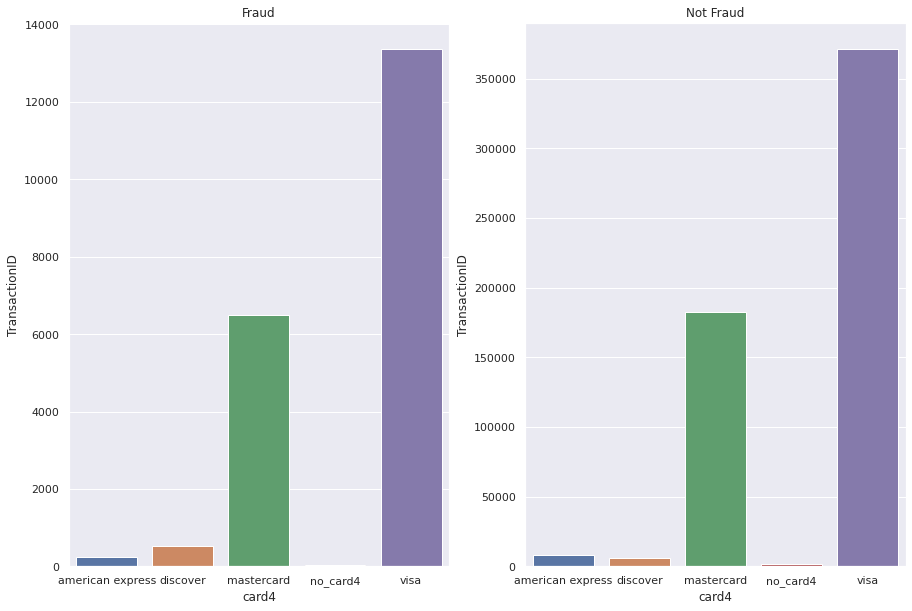

In [13]:
card_cols = ['card4', 'card6']
fig, ax = plt.subplots(1, len(card_cols), figsize=(15, 10))

train_transaction['card4'].fillna('no_card4', inplace=True)

grouped_card4 = train_transaction.groupby([card_cols[0], 'isFraud'])['TransactionID'].count().reset_index()

for i, prod in enumerate(['1', '0']):
  tmp = grouped_card4.query(f'isFraud == "{prod}"')
  sns.barplot(data=tmp,
              x='card4',
              y='TransactionID',
              ax=ax[i])
ax[0].set_title('Fraud')
ax[1].set_title('Not Fraud')

Особой разницы между транзакциями с меткой и без метки фрода нет. 
#### card6

Text(0.5, 1.0, 'Not Fraud')

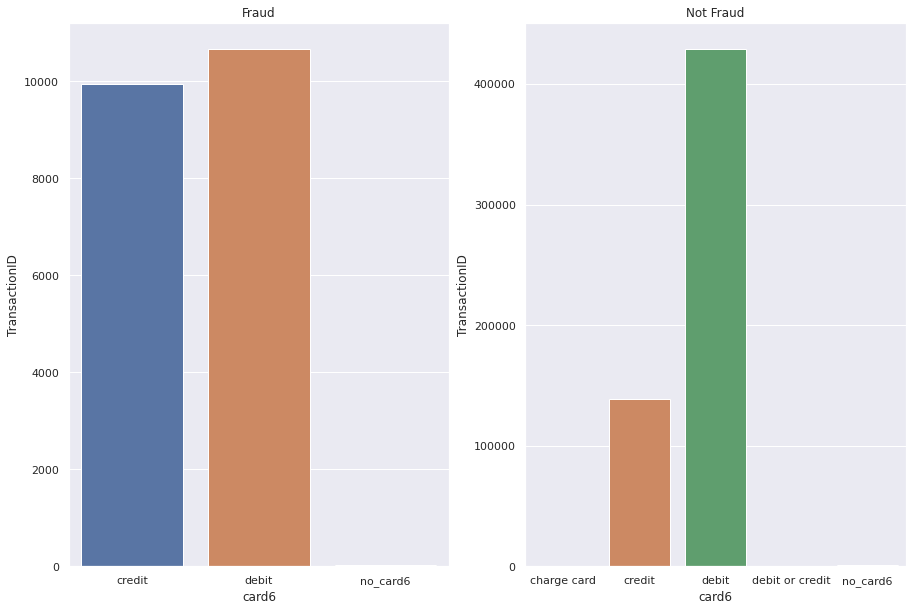

In [14]:
card_cols = ['card6']
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

train_transaction['card6'].fillna('no_card6', inplace=True)

grouped_card6 = train_transaction.groupby([card_cols[0], 'isFraud'])['TransactionID'].count().reset_index()

for i, prod in enumerate(['1', '0']):
  tmp = grouped_card6.query(f'isFraud == "{prod}"')
  sns.barplot(data=tmp,
              x='card6',
              y='TransactionID',
              ax=ax[i])
ax[0].set_title('Fraud')
ax[1].set_title('Not Fraud')

У транзакций с меткой фрод больше классов признака card6 и больше объектов класса debit.

### addr1 - addr2

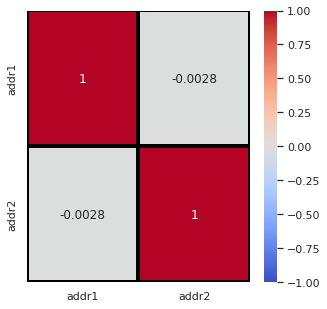

In [15]:
params = ['addr1', 'addr2']

plt.figure(figsize=(5, 5))
sns.heatmap(
    train_transaction[params].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    linewidths=3,
    linecolor="black",
)  # роп для линейных моделей коррелирущие признаки

Text(0.5, 1.0, 'Not Fraud')

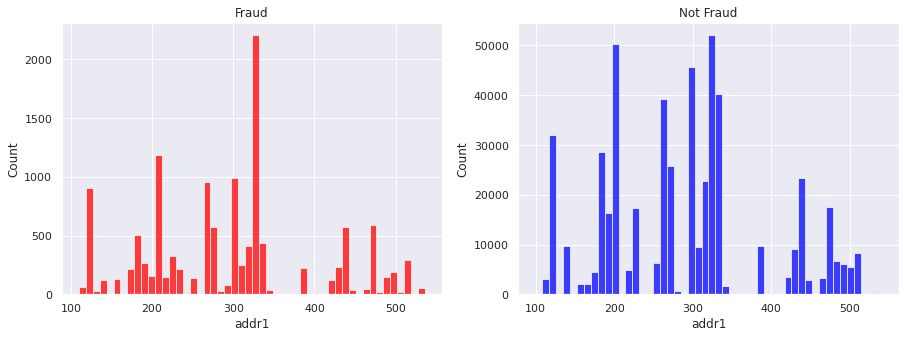

In [16]:
params = {
    'x': "addr1",
    'bins': 50,
    'log_scale': False
}

params_fraud = {
    'data': train_transaction.query('isFraud == "1"'),
    'color': 'red'
}

params_not_fraud = {
    'data': train_transaction.query('isFraud == "0"'),
    'color': 'blue'
}

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(**params_fraud, 
             **params, 
             ax=ax[0])
sns.histplot(**params_not_fraud,
             **params, 
             ax=ax[1])

ax[0].set_title('Fraud')
ax[1].set_title('Not Fraud')

Text(0.5, 1.0, 'Not Fraud')

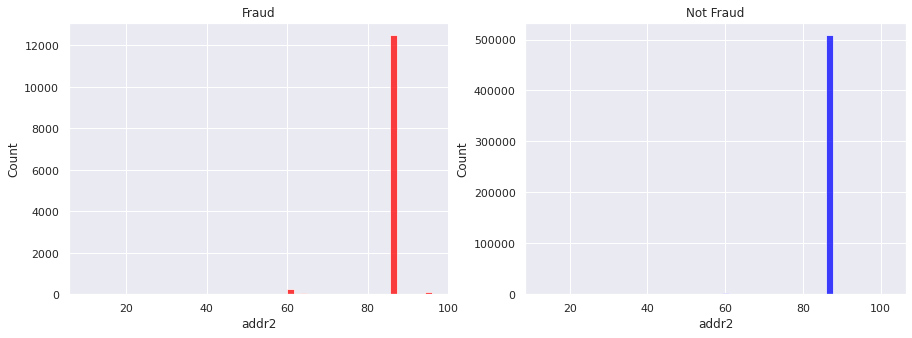

In [17]:
params['x'] = 'addr2'

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(**params_fraud, 
             **params, 
             ax=ax[0])
sns.histplot(**params_not_fraud,
             **params, 
             ax=ax[1])

ax[0].set_title('Fraud')
ax[1].set_title('Not Fraud')

Не совсем понятные признаки, посмотрим, как они перформят в модели.

### dist

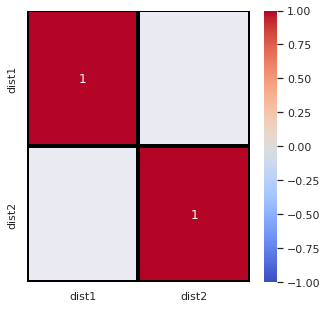

In [18]:
params = ['dist1', 'dist2']

plt.figure(figsize=(5, 5))
sns.heatmap(
    train_transaction[params].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    linewidths=3,
    linecolor="black",
)  # роп для линейных моделей коррелирущие признаки

Text(0.5, 1.0, 'Not Fraud')

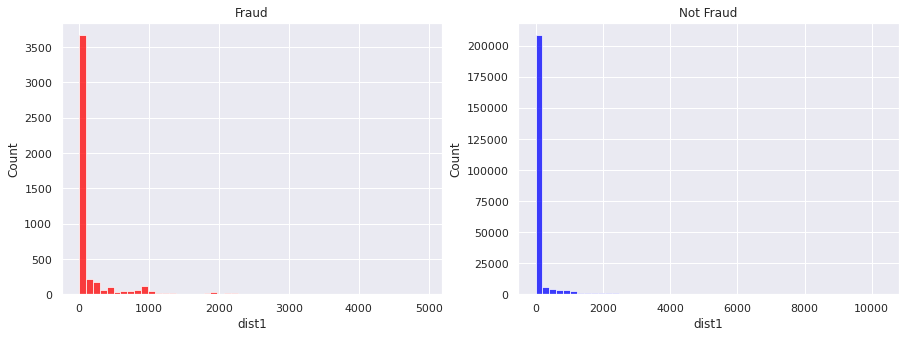

In [19]:
params = {
    'x': "dist1",
    'bins': 50,
    'log_scale': False
}

params_fraud = {
    'data': train_transaction.query('isFraud == "1"'),
    'color': 'red'
}

params_not_fraud = {
    'data': train_transaction.query('isFraud == "0"'),
    'color': 'blue'
}

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(**params_fraud, 
             **params, 
             ax=ax[0])
sns.histplot(**params_not_fraud,
             **params, 
             ax=ax[1])

ax[0].set_title('Fraud')
ax[1].set_title('Not Fraud')

Необходимо будет прологорифмировать перед тем, как отдать модели. Видно, что dist1 для транзакций с метками фрод и не фрод отличаются. У обычных транзакций признак варьируется от 0 до 10000. У фрода - до 5000. 

Text(0.5, 1.0, 'Not Fraud')

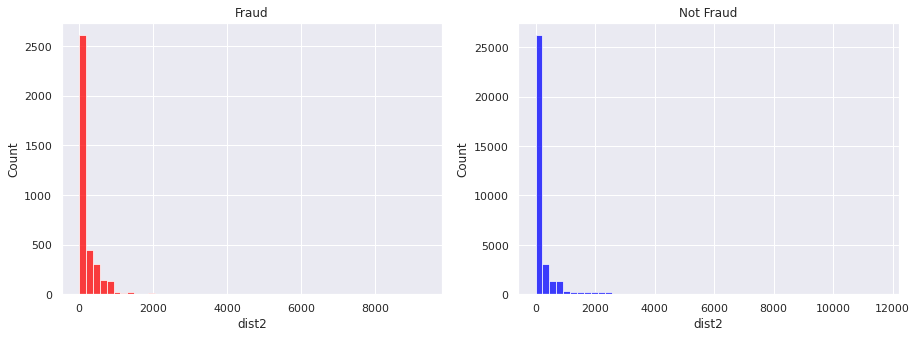

In [20]:
params['x'] = 'dist2'
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(**params_fraud, 
             **params, 
             ax=ax[0])
sns.histplot(**params_not_fraud,
             **params, 
             ax=ax[1])

ax[0].set_title('Fraud')
ax[1].set_title('Not Fraud')

Аналогично, как и с прошлым признаком, его придется прологорифмировать. Для фрода и не фрода различается. 

### P_emaildomain

In [21]:
train_transaction['P_emaildomain'].fillna('no_P_emaildomain', inplace=True)
cols = ['P_emaildomain', 'isFraud']

grouped_P_emaildomain = train_transaction.groupby(cols)['TransactionID'].count().reset_index()

nom = grouped_P_emaildomain.query('isFraud == "0"').set_index(cols)['TransactionID']
denom = grouped_P_emaildomain.query('isFraud == "0"').set_index(cols).TransactionID.sum()

(nom/denom * 100).reset_index().sort_values('TransactionID', ascending=False).head(10)

,P_emaildomain,isFraud,TransactionID
16,gmail.com,0,38.326165
54,yahoo.com,0,17.308472
34,no_P_emaildomain,0,16.085225
19,hotmail.com,0,7.519868
1,anonymous.com,0,6.341544
2,aol.com,0,4.855785
9,comcast.net,0,1.340991
23,icloud.com,0,1.065142
36,outlook.com,0,0.809648
3,att.net,0,0.702432


In [22]:
train_transaction['P_emaildomain'].fillna('no_P_emaildomain', inplace=True)
cols = ['P_emaildomain', 'isFraud']

grouped_P_emaildomain = train_transaction.groupby(cols)['TransactionID'].count().reset_index()

nom = grouped_P_emaildomain.query('isFraud == "1"').set_index(cols)['TransactionID']
denom = grouped_P_emaildomain.query('isFraud == "1"').set_index(cols).TransactionID.sum()

(nom/denom * 100).reset_index().sort_values('TransactionID', ascending=False).head(10)

,P_emaildomain,isFraud,TransactionID
14,gmail.com,1,48.119828
26,no_P_emaildomain,1,13.502396
15,hotmail.com,1,11.595606
38,yahoo.com,1,11.116488
1,anonymous.com,1,4.157189
2,aol.com,1,2.986014
28,outlook.com,1,2.332672
7,comcast.net,1,1.190534
17,icloud.com,1,0.953395
22,mail.com,1,0.512994


почт с доменом gmail в транзакциях с фродом больше. видимо, используют самый популярный домен, чтобы не выделяться.

### R_emaildomain

In [23]:
train_transaction['R_emaildomain'].fillna('no_R_emaildomain', inplace=True)
cols = ['R_emaildomain', 'isFraud']

grouped_R_emaildomain = train_transaction.groupby(cols)['TransactionID'].count().reset_index()

nom = grouped_R_emaildomain.query('isFraud == "0"').set_index(cols)['TransactionID']
denom = grouped_R_emaildomain.query('isFraud == "0"').set_index(cols).TransactionID.sum()

(nom/denom * 100).reset_index().sort_values('TransactionID', ascending=False).head(10)

,R_emaildomain,isFraud,TransactionID
34,no_R_emaildomain,0,77.878735
16,gmail.com,0,8.832783
19,hotmail.com,0,4.451662
1,anonymous.com,0,3.497421
55,yahoo.com,0,1.970952
2,aol.com,0,0.626802
36,outlook.com,0,0.367272
9,comcast.net,0,0.314278
56,yahoo.com.mx,0,0.261811
23,icloud.com,0,0.213730


In [24]:
train_transaction['R_emaildomain'].fillna('no_R_emaildomain', inplace=True)
cols = ['R_emaildomain', 'isFraud']

grouped_R_emaildomain = train_transaction.groupby(cols)['TransactionID'].count().reset_index()

nom = grouped_R_emaildomain.query('isFraud == "1"').set_index(cols)['TransactionID']
denom = grouped_R_emaildomain.query('isFraud == "1"').set_index(cols).TransactionID.sum()

(nom/denom * 100).reset_index().sort_values('TransactionID', ascending=False).head(10)

,R_emaildomain,isFraud,TransactionID
19,no_R_emaildomain,1,45.666167
8,gmail.com,1,32.962300
9,hotmail.com,1,10.356676
28,yahoo.com,1,2.952137
1,anonymous.com,1,2.894062
21,outlook.com,1,2.003581
11,icloud.com,1,0.871122
2,aol.com,1,0.624304
22,outlook.es,1,0.275855
15,mail.com,1,0.222620


Тоже интересно наблюдение. Фродеры чаще пытаются заполнять почту получателя + используют самые популярные домены.

### C1-C14

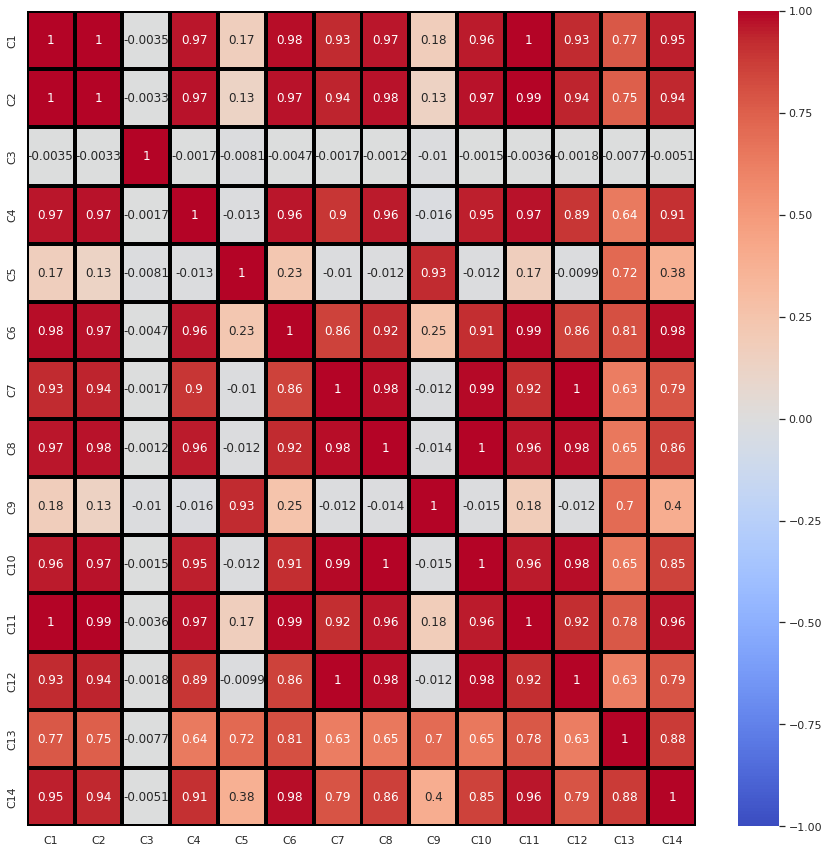

In [25]:
c_params = ["C" + str(i) for i in range(1, 15)]

plt.figure(figsize=(15, 15))
sns.heatmap(
    train_transaction[c_params].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    linewidths=3,
    linecolor="black",
)

Ну, тут проще выписать только те признаки, между которыми нет корреляции.   
Оставим только:  C1, С3, C5, C9 и C13

### D1-D15

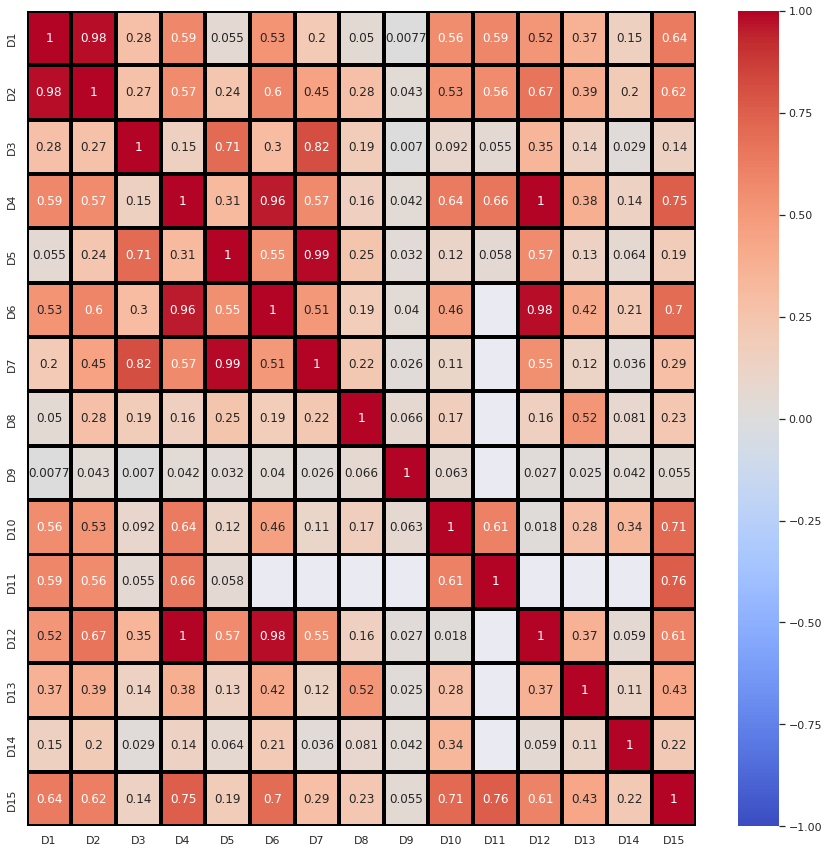

In [26]:
d_params = ["D" + str(i) for i in range(1, 16)]

plt.figure(figsize=(15, 15))
sns.heatmap(
    train_transaction[d_params].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    linewidths=3,
    linecolor="black",
)  # роп для линейных моделей коррелирущие признаки

Наиболее коррелирующие пары признаков:  
* D1 и D2
* D6 и D4
* D7 и D5
* D7 и D3
* D12 и D4
* D12 и D6

Как итог, имеет смысл оставить только признаки: D1, D7, D8, D9, D10, D11, D12

### M1-M9

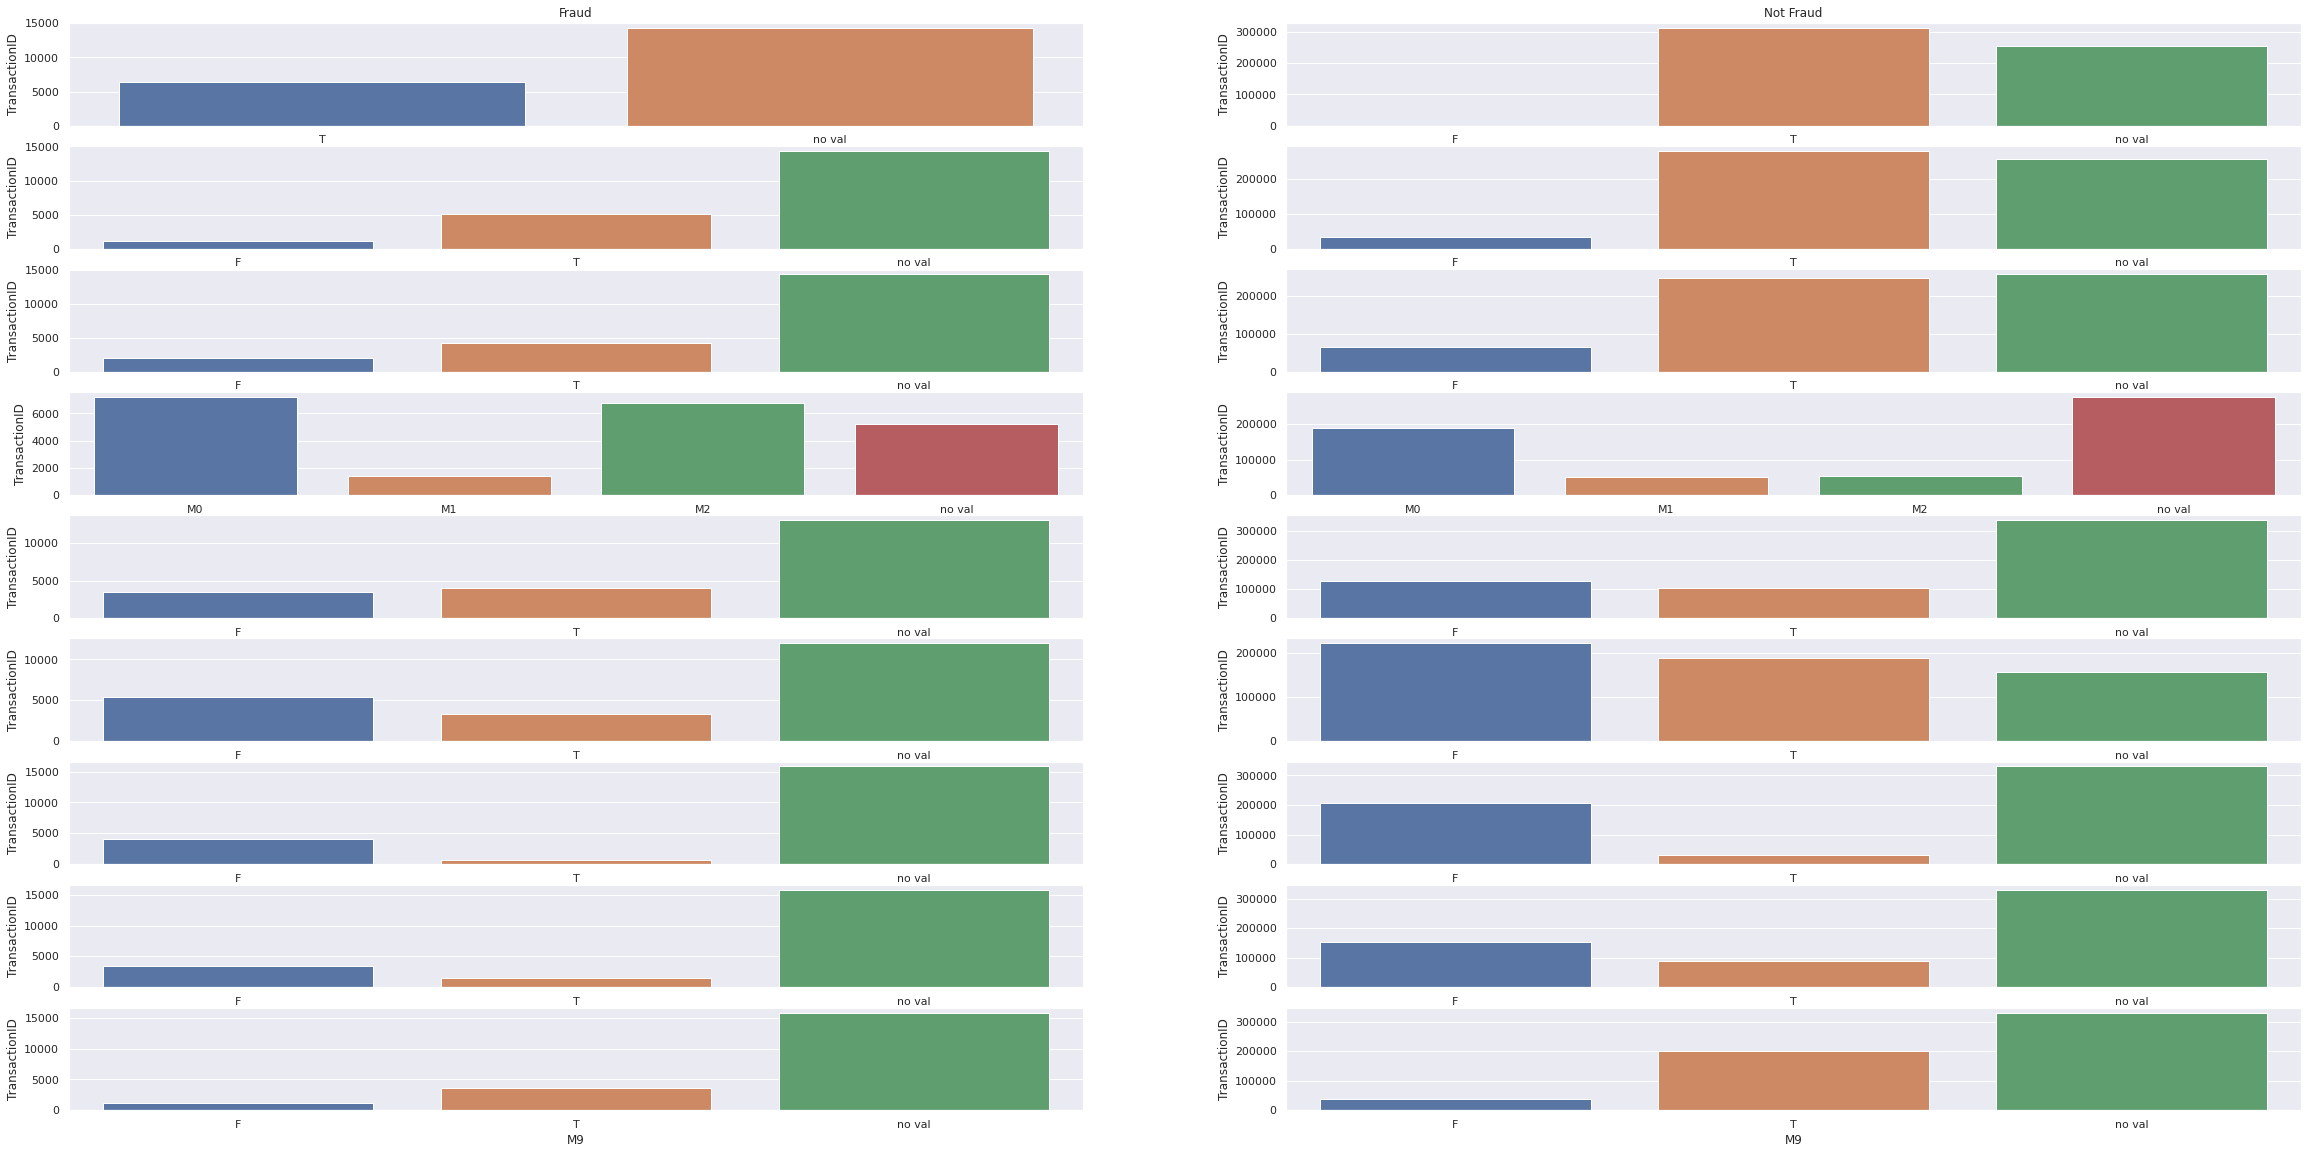

In [27]:
m_params = ["M" + str(i) for i in range(1, 10)]

train_transaction[m_params] = train_transaction[m_params].fillna('no val')

fig, ax = plt.subplots(len(m_params), 2, figsize=(40, 20))

for i, m in enumerate(m_params):

  grouped = train_transaction.groupby([m, 'isFraud'])['TransactionID'].count().reset_index()

  for j, prod in enumerate(['1', '0']):
    tmp = grouped.query(f'isFraud == "{prod}"')
    sns.barplot(data=tmp,
                x=m,
                y='TransactionID',
                ax=ax[i][j])
    

ax[0][0].set_title('Fraud')
ax[0][1].set_title('Not Fraud')

plt.show()

Заполнение пропусков особо ничего не дает. Однако, есть ряд признаков, которые сильно отличаются между классами фрод и не фрод. К таким признакам относятся: M1 (с меткой фрода только один класс), M2, M3, M4, M6 и M9.


### Vxxx

In [28]:
v_cols = [c for c in train_transaction if c[0] == 'V']

In [29]:
train_transaction[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [36]:
corrV = train_transaction[v_cols].corr()

In [60]:
pairs = dict()

for v in v_cols:
  tmp = corrV[corrV[v] > 0.8][v].index
  tmp = [ind for ind in tmp if ind != v]
  if len(tmp):
    pairs[v] = tmp

In [79]:
len_v_k = [(len(v), k) for k, v in pairs.items()]

sorted(len_v_k)[::-1][:5]

[(66, 'V329'), (63, 'V324'), (63, 'V213'), (63, 'V168'), (62, 'V323')]

In [80]:
# возьмем те признаки, которые не коррелируют ни с какими другими
v_cols_to_take = list(set(v_cols) - set(pairs.keys()))

In [81]:
# теперь пробежимся по коррелирующим парам. оставим только те, которые коррелируют с большим числом признаков.
v_cols_not_to_take = []

for len_v, col in sorted(len_v_k)[::-1]:
   if col not in v_cols_not_to_take:
     v_cols_to_take.append(col)
     v_cols_not_to_take.extend(pairs[col])

In [82]:
print('Коррелирующих между собой признаков: %i' % len(pairs.keys()))

Коррелирующих между собой признаков: 300


In [83]:
print('Кол-во признаков, которые имеет смысл оставить: %i' % len(v_cols_to_take))

Кол-во признаков, которые имеет смысл оставить: 104


In [88]:
for col in v_cols_to_take:
  v_col_mean = train_transaction[col].mean()
  train_transaction.loc[train_transaction[col].isna(), col] = v_col_mean

Пока не совсем понятно, что делать с этим признаком. Имеет смысл посмотреть, занулит ли модель веса у каких-то из этих признаков. Пока оставим только те, которые не коррелируют друг с другом.

### DeviceType

In [97]:
X_train = train_transaction.merge(train_identity, how='outer', on='TransactionID')

Text(0.5, 1.0, 'Not Fraud')

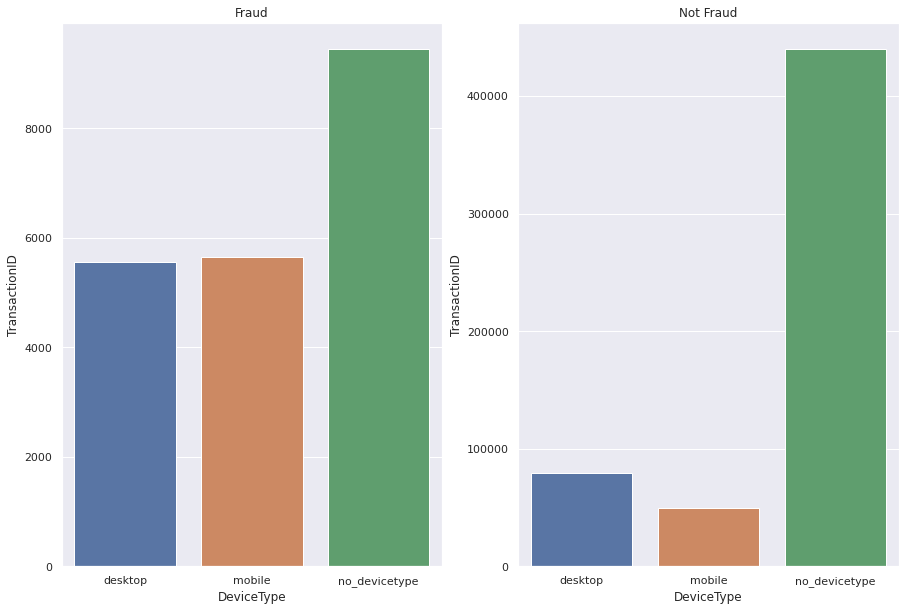

In [99]:
device_cols = ['DeviceType', 'isFraud']
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

X_train['DeviceType'].fillna('no_devicetype', inplace=True)

grouped = X_train.groupby(device_cols)['TransactionID'].count().reset_index()

for i, prod in enumerate(['1', '0']):
  tmp = grouped.query(f'isFraud == "{prod}"')
  sns.barplot(data=tmp,
              x='DeviceType',
              y='TransactionID',
              ax=ax[i])
ax[0].set_title('Fraud')
ax[1].set_title('Not Fraud')

## DeviceInfo

In [100]:
X_train['DeviceInfo'].fillna('no_deviceinfo', inplace=True)
cols = ['DeviceInfo', 'isFraud']

grouped = X_train.groupby(cols)['TransactionID'].count().reset_index()

nom = grouped.query('isFraud == "0"').set_index(cols)['TransactionID']
denom = grouped.query('isFraud == "0"').set_index(cols).TransactionID.sum()

(nom/denom * 100).reset_index().sort_values('TransactionID', ascending=False).head(10)

,DeviceInfo,isFraud,TransactionID
1698,no_deviceinfo,0,80.687236
1565,Windows,0,7.826426
1684,iOS Device,0,3.253685
712,MacOS,0,2.157483
1520,Trident/7.0,0,1.288699
1700,rv:11.0,0,0.320245
1724,rv:57.0,0,0.150734
1334,SM-J700M Build/MMB29K,0,0.085808
1178,SM-G610M Build/MMB29K,0,0.074402
1168,SM-G531H Build/LMY48B,0,0.066155


In [101]:
X_train['DeviceInfo'].fillna('no_deviceinfo', inplace=True)
cols = ['DeviceInfo', 'isFraud']

grouped = X_train.groupby(cols)['TransactionID'].count().reset_index()

nom = grouped.query('isFraud == "1"').set_index(cols)['TransactionID']
denom = grouped.query('isFraud == "1"').set_index(cols).TransactionID.sum()

(nom/denom * 100).reset_index().sort_values('TransactionID', ascending=False).head(10)

,DeviceInfo,isFraud,TransactionID
402,no_deviceinfo,1,58.345836
360,Windows,1,15.104293
398,iOS Device,1,6.001065
148,MacOS,1,1.345400
397,hi6210sft Build/MRA58K,1,0.871122
254,SM-A300H Build/LRX22G,1,0.817887
416,rv:57.0,1,0.498476
354,Trident/7.0,1,0.464599
403,rv:11.0,1,0.367807
94,LG-D320 Build/KOT49I.V10a,1,0.295214


Почему-то опять у большего числа фрод транзакций известен тип устройства и информация о нем, через который была совершена транзакция.